<a href="https://colab.research.google.com/github/GeorgeWilliam1999/Data-Science-UOS/blob/main/GPU_coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Task 1

Bellow is the addapted discretisation function. The changes made are the addition of assignable boundary conditions given by the parameter 'fung' and interior equation 'funf'. Both functions are clearly displayed below.

We consider a trial function $u = e^{(x-\frac{1}{2})^2+(y-\frac{1}{2})}$ and attempt to solve it using the approximation given in the assigment: 

Interior equation (funf): $-\Delta u = f(x,y) := e^{(x-\frac{1}{2})^2+(y-\frac{1}{2})}$, $x,y \in \Omega $

Bounday condition (fung) : $g(x,y) := e^{(x−\frac{1}{2})+(y-\frac{1}{2})} \forall x,y \in \Gamma$

Note that fung is the second derivative of the trial function.

In [2]:
import numpy as np
from scipy.sparse import coo_matrix
def funf(x,y): #Define the internal function on the unit square.
  return -((2*x-1)**2+(2*y-1)**2+4)*np.exp((x-0.5)**2+(y-0.5)**2)

def fung(x,y): #Define boundary conditions on the unit square.
  return np.exp((x-0.5)**2+(y-0.5)**2)

def discretise_poisson(N,funf ,fung): #N:Dimension of grid funf: negative laplacian function fung:boundary condition
    """Generate the matrix and rhs associated with the discrete Poisson operator."""
    
    nelements = 5 * N**2 - 16 * N + 16 #Find the number of non zero elements.
    h = 1/(N + 1)
    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    f = np.empty(N * N, dtype=np.float64)
    
    count = 0
    for j in range(N):
        for i in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  1
                f[j * N + i] = fung(h*i,h*j)
                count += 1
                
            else:
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i
                                
                data[count] = 4 * (N - 1)**2
                data[count + 1 : count + 5] = - (N - 1)**2
                f[j * N + i] = funf(h*i,h*j)
                
                count += 5
                                                
    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr(), f #Return a sparse matrix with the column and row indicies found above.

##Plot function

Now that we have a function that reduces the probelm to a linear system of the form $Ax = f$ where $f$ is the vector of components of each point. We need to find the values of $x$ which contains the pointwise values of $u(x,y)$ in vectorised $(u \in \mathbb{R}^{N^2})$ form. 

First apply the above distritisation function with the interior equation and boundary condition and apply the scipy sparce matrix solver function, next $x$ is reshaped to match the domain $[0,1] \times [0,1]$ and plotted.

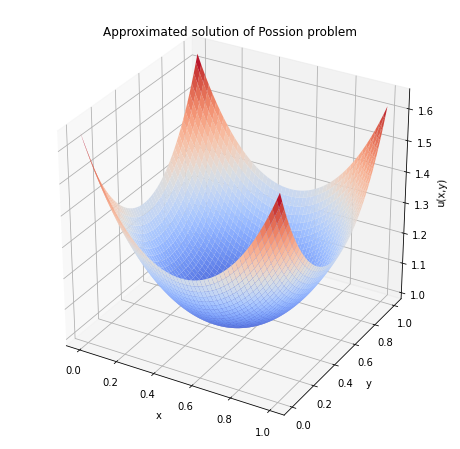

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from scipy.sparse.linalg import spsolve

N = 200

A, f = discretise_poisson(N,funf,fung)
sol = spsolve(A, f)

u = sol.reshape((N, N))

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
ticks= np.linspace(0, 1, N)
X, Y = np.meshgrid(ticks, ticks)
surf = ax.plot_surface(X, Y, u, antialiased=True, cmap=cm.coolwarm)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x,y)')
ax.set_title('Approximated solution of Possion problem')
plt.show()


##Errors and Conjecture

The above approximation is now compared to the true value of the function on all points of the domain, the variable u_exact is set to fung which is the true function. The relative error is given by $\frac{|u(x,y)-u_{exact}(x,y)|}{|u_{exact}(x,y)|}|$ at each point. I create two functions, the first to compute and store the true values and the second to find the difference between the two functions, and return the largest pointwise difference for each value of N.

In [4]:
#Compute exact values 
def Exact(fung,N):
  #Create dummy array full of zeros
  u_exact = np.zeros(shape = (N,N))
  h = 1/(N+1) #define the interval length
  for i in range(N): 
    for j in range(N):
      u_exact[i,j] =  fung(h*i,h*j) #Compute the true function value at leach point
  return u_exact


#Compute the pointwise relative error 
def err_relative(u,u_exact,N):
  e_rel = np.zeros(shape=(N**2)) #empty array of lengeth N^2
  for i in range(N):
    for j in range(N):
      e_rel[i + j*N] = np.linalg.norm(u[i,j] - u_exact[i,j]) / np.linalg.norm(u_exact[i,j])
  return e_rel.max()

I now call the above functions for a set of trial values of N, the goal being to determine if there is a relationship between the value of N and the largest pointwise error.

In [5]:
recorder = np.zeros(shape = 40) #Array to store largest errors
trials = np.arange(5,205,5) #Set of chosen values of N to trial
c=0 #Counter fo recoder indexing

for n in trials: 

  A, f = discretise_poisson(n,funf,fung) #Define linear system
  sol = spsolve(A, f) #Solve linear system

  u = sol.reshape((n, n)) #Reshape solution

  u_exact = Exact(fung,n) #Find true solution for given N

  recorder[c] = err_relative(u,u_exact,n) #Add lowestr error the cth array element.
  c += 1
recorder

array([0.1716956 , 0.10489149, 0.07738762, 0.06013185, 0.04958197,
       0.04192983, 0.03646528, 0.0321643 , 0.02883513, 0.02608317,
       0.0238452 , 0.02193421, 0.02032739, 0.01892336, 0.01771403,
       0.01663902, 0.01569607, 0.01484662, 0.01409084, 0.01340275,
       0.01278348, 0.01221477, 0.01169811, 0.0112202 , 0.01078262,
       0.01037539, 0.01000002, 0.00964887, 0.00932333, 0.00901743,
       0.00873242, 0.00846355, 0.00821195, 0.00797377, 0.00775003,
       0.00753757, 0.0073373 , 0.00714662, 0.00696632, 0.00679422])

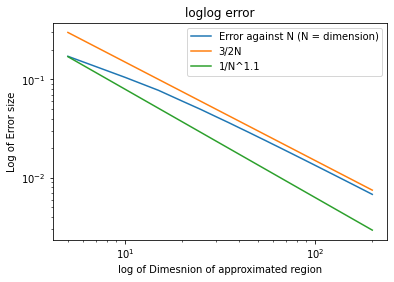

In [6]:
#Plotting erros against dimension
plt.loglog(trials,recorder,label = 'Error against N (N = dimension)')
plt.loglog(trials,1.5/((trials)), label = '3/2N')
plt.loglog(trials,1/((trials)**1.1), label = '1/N^1.1')
plt.xlabel('log of Dimesnion of approximated region')
plt.ylabel('Log of Error size')
plt.legend(loc="best")
plt.title('loglog error')
plt.show()

Above I display the log(error) against the log(dimesion) $(log(N))$ not $log(N^2))$. We can clearly see that the error is approximatly negative log linear. To help see this I have added a loglog plot of $\frac{3}{2N}$ which is exactly negative log linear.

Further more, comparing these curves to the loglog of $\frac{1}{N^{1.1}}$ we can see the error is sandwiched between both comparison functions. Due to this I consider the sandwich theorem which states that if a function is bound from above and below by functions that converge to some limit, then so too does the bound function. Hence I conjecture that the rate of convergence is between $O(N)$ and $O(N^{1.1})$.



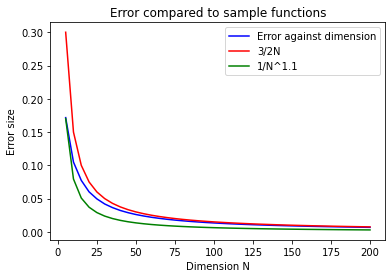

In [7]:
#Plotting erros against dimension
plt.plot(trials,recorder,'-b',label = 'Error against dimension')
plt.plot(trials,3/(2*(trials)),'-r', label = '3/2N')
plt.plot(trials,1/((trials)**1.1),'-g', label = '1/N^1.1')
plt.xlabel('Dimension N')
plt.ylabel('Error size')
plt.title('Error compared to sample functions')
plt.legend(loc="best")
plt.show()

The above plot helps confirm this, the error term appears to remain between $y = \frac{3}{2N}$ and $y = \frac{1}{N^{1.1}}$.
Below I take the difference between the error terms and the sample functions considered above. Since they both converge to 0 we see that the error term goes to 0 slower than $O(N^{1.1})$ but faster that $O(N)$.

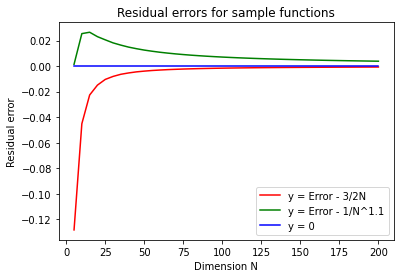

In [8]:
#Plotting erros against dimension
plt.plot(trials,recorder- 3/(2*(trials)),'-r',label = 'y = Error - 3/2N')
plt.plot(trials,recorder- 1/((trials)**1.1),'g',label = 'y = Error - 1/N^1.1')
plt.plot(trials,np.zeros(40),'b',label = 'y = 0')
plt.ylabel('Residual error')
plt.xlabel('Dimension N')
plt.title('Residual errors for sample functions')
plt.legend(loc="best")
plt.show()

#Task 2

In this task I create and implement an iterative scheme to solve linear system for the correct values if $u(x,y)$. 

The scheme is of the form 
$u^{k+1}(x_i,y_j) = \frac{1}{4}(h^2f(x_i,y_j) + u^k(x_{i-1}. y_j) + u^k(x_{i+1}, y_j) + u^k(x_i, y_{j-1}) + u^k(x_i, y_{j+1}))$.

I will first vectorise the problem to obtain a system of the form $\hat{u}^{k+1} = \frac{1}{4}A\hat{u}^k + \frac{h^2}{4}\hat{f}$. Note that the factor of 1/4 will be absorbed in the the matrix A.

The vector $\hat{u}^0$ will be initiated with 0 in each slot that correpsonds to an interior point of the grid. Slots that correspond to a boundary will be set to the value of the boundary and will not be updated at all. The f vector is constant and is set to the value of the second derivate at all points, except the bounday points which will be set to 0 since they are. accounted for in the vector $\hat{u}^k$.


The first thing to do it make changes to the discretisation function, the matrix $A$ and vecror $f$ are both being repurposed. The matrix $A$ needs to 
encode the coefficients for each spartial dependancy. To do this it will be diagonal with values of 1 for the boundary condition to ensure that the boundarys (BC) are respected. None boundary matrix elements are $\frac{1}{4}$ to respect the factor of 4 in the itterative scehem. An example system can be found bellow.
 

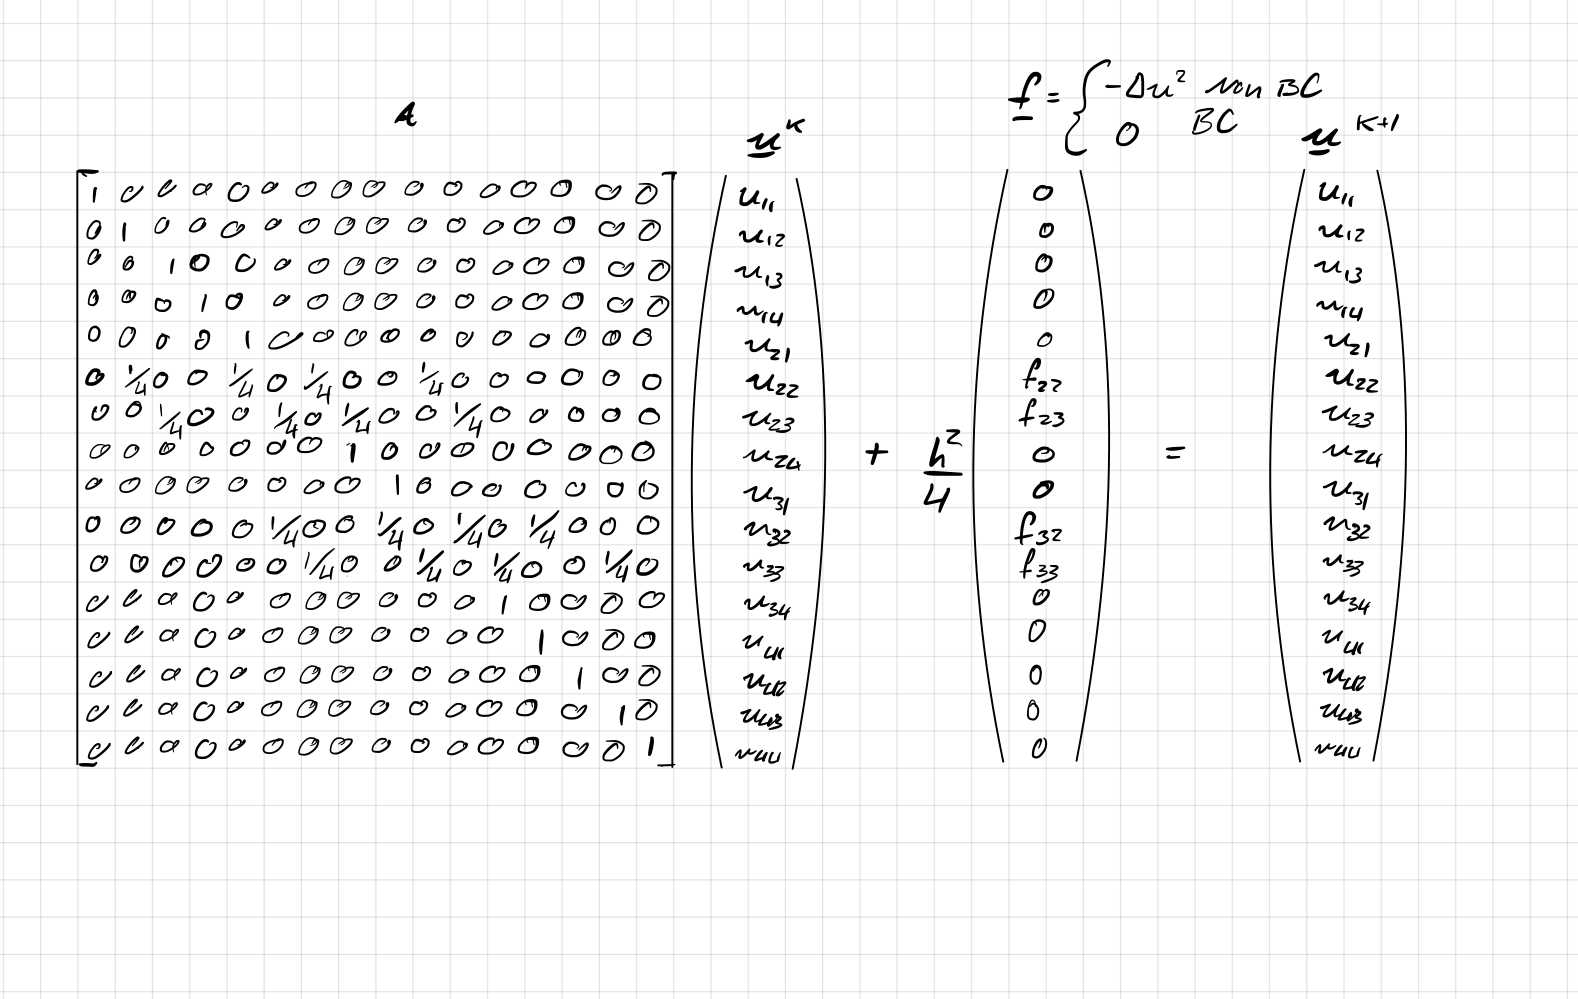

Also note the the new scheme requires a matrix with a differing number of elements. For the $(N-1)$ boundy elements there is a contribution of 1 element on the diagnal, and the $(N-2)^2$ interior points contribute 4 elements in all corresponding rows. This leads to a total of $4(N-1) + 4(N-2)^2$ none-zero matrix elements.

In [9]:
def discretise_itter(N,funf ,fung): #N:Dimension of grid funf: negative laplacian function fung:boundary condition
    """Generate the matrix and rhs associated with the discrete Poisson operator."""
    
    nelements = 4*(N-1)+4*(N-2)**2 #Find the number of non zero elements.
    h = 1/(N + 1) #Define interval size
    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    f = np.empty(N * N, dtype=np.float64)
    
    count = 0
    for j in range(N):
        for i in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  1 #Set all diagonal entries to 1
                f[j * N + i] = 0 #Set component of f corresponding to BCs to be 0
                count += 1
                
            else:
                row_ind[count : count + 4] = j * N + i 
                col_ind[count] = j * N + i + 1
                col_ind[count + 1] = j * N + i - 1
                col_ind[count + 2] = (j + 1) * N + i
                col_ind[count + 3] = (j - 1) * N + i
                                
                
                data[count : count + 4] = 1/4 #Set non boundary contributions to be 1/4
                f[j * N + i] = (h**2)*funf(i*h,j*h)/4 #Set non BC components of f to the negative laplacian.
                
                count += 4
                                                
    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr(), f #Return a sparse matrix with the column and row indicies found above.

##Demonstration using N = 100

To test the itterative approach I choose a grid of size 20 by 20 and run 100 itterations. The error achived here is very low, but for a grid with higher resolution such low errors will be much hard to achive due to the amount of time required to perform the actual computation. 

In [10]:
N = 4 #Set grid size
A,f = discretise_itter(N,funf ,fung) #Discretise the system

In [11]:
#Define starting values of u_0 as discussed above
u = np.zeros(shape = N**2) 
h = 1/(N+1)
for i in range(N): #Row space
  for j in range(N): #Column Space
    if j == 0 or j == N - 1 or i == 0 or i == N - 1: #If on the boundary
      u[j*N+i] = fung(i*h,j*h)
    else: #Else not on the boundary
      u[j*N+i] = 0

In [12]:
import numba
@numba.jit(nopython=True, parallel=True)
def csr_matvec(data, indices, indptr, shape, x, f,iters):
    """Evaluates the matrix-vector product with a CSR matrix."""
    # Get the rows and columns
    
    m, n = shape
    
    
    for i in range(iters):      
      y = np.zeros(m, dtype=np.float64) #replace with buffer 1

      for row_index in numba.prange(m):
          col_start = indptr[row_index]
          col_end = indptr[row_index + 1]
          for col_index in range(col_start, col_end):
              y[row_index] += data[col_index] * x[indices[col_index]]
          y[row_index] += f[row_index]    

      x = y  #replace with buffer 2
    return y

In [13]:
p = csr_matvec(A.data, A.indices, A.indptr, A.shape, u,f,10000)
p

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


array([1.64872127, 1.40494759, 1.29693009, 1.29693009, 1.40494759,
       1.19963722, 1.10734417, 1.10517092, 1.29693009, 1.10734417,
       1.02214854, 1.02020134, 1.29693009, 1.10517092, 1.02020134,
       1.02020134])

Bellow is an example of parallelisable code for the matrix vector product and vector vector addition. This logic will be carried forward and adapted to be used on a GPU.

In [14]:
A.data, A.indices, A.indptr

(array([1.  , 1.  , 1.  , 1.  , 1.  , 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
        0.25, 0.25, 1.  , 1.  , 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
        0.25, 1.  , 1.  , 1.  , 1.  , 1.  ]),
 array([ 0,  1,  2,  3,  4,  1,  4,  6,  9,  2,  5,  7, 10,  7,  8,  5,  8,
        10, 13,  6,  9, 11, 14, 11, 12, 13, 14, 15], dtype=int32),
 array([ 0,  1,  2,  3,  4,  5,  9, 13, 14, 15, 19, 23, 24, 25, 26, 27, 28],
       dtype=int32))

In [15]:
u_exact = Exact(fung,N).reshape(N,N) #Find true solution for given N

err_relative(p.reshape(N,N),u_exact,N)

0.002021235577027643

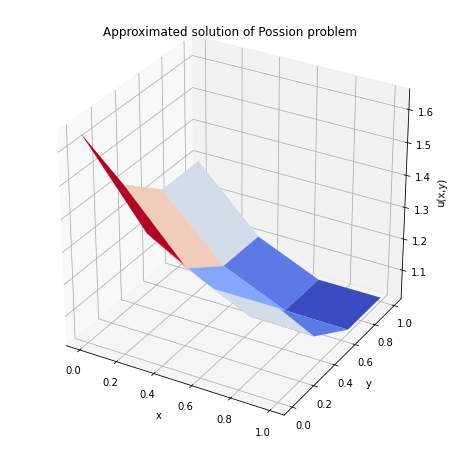

In [16]:
 u = p.reshape((N, N))

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
ticks= np.linspace(0, 1, N)
X, Y = np.meshgrid(ticks, ticks)
surf = ax.plot_surface(X, Y, u, antialiased=True, cmap=cm.coolwarm)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x,y)')
ax.set_title('Approximated solution of Possion problem')
plt.show()

#GPU implementation

The scheme has been reduced to a linear system of a matrix vector product and vector vector addition. This can be performed element wise in small warps with enough threads and local memory for their associated variables.

In [17]:
@numba.jit(nopython=True, parallel=True)
def csr_matvec(data, indices, indptr, shape, x, f,iters):
    """Evaluates the matrix-vector product with a CSR matrix."""
    # Get the rows and columns
    
    m, n = shape
    
    
    for i in range(iters):      
      y = np.zeros(m, dtype=np.float64) #replace with buffer 1

      for row_index in numba.prange(m):

          col_start = indptr[row_index]
          col_end = indptr[row_index + 1]
          for col_index in range(col_start, col_end):
              y[row_index] += data[col_index] * x[indices[col_index]]
              
          y[row_index] += f[row_index]    

      x = y  #replace with buffer 2
    return y

In [18]:
#Create Au+f kernel 
SX = 32
SY = 4*(N-1)+4*(N-2)**2
v = np.zeros(N**2)
#4*(N-1)+4*(N-2)**2
nblocks = (u.shape[0] + SX -1) // SX
@cuda.jit
def GPU_ker(data, indices, indptr, u, f, v):
  #Specify local shared memory
  local_v = cuda.shared.array((SX,1),numba.float32)
  local_f = cuda.shared.array((SX,1),numba.float32)
  local_u = cuda.shared.array((SX,1),numba.float32)
  local_data = cuda.shared.array((SY,1),numba.int32)
  local_indices = cuda.shared.array((SY,1),numba.int32)
  local_indptr = cuda.shared.array((SY,1),numba.int32)

  #Local thread location 
  tx = cuda.threadIdx.x
  #ty = cuda.threadIdx.y
 
  #Global position
  px = cuda.grid(1)

  
  local_v[tx] = v[px]
  local_f[tx] = f[px]
  local_u[tx] = u[px]

  for i in range(SY):
    local_data[i,1] = data[i]
    local_indices[i,1] = indices[i]
    local_indptr[i,1] = indptr[i]

  cuda.syncthreads()

  col_start = indptr[tx]
  col_end = indptr[tx + 1]
  for col_index in range(col_start, col_end):
      v[tx] += data[col_index] * u[indices[col_index]]
      
  v[tx] += f[tx]
  u[px] = v[tx]


  #if tx == 0:
  #  local_data[ty] = data[py]
  #  local_indices[ty] = indices[py]
  #  local_indptr[ty] = indptr[py]



GPU_ker[(nblocks,1),(SX,SY)](A.data.astype('float32'), A.indices.astype('int32'), A.indptr.astype('int32'), u.astype('float32'), f.astype('float32'), v.astype('float32'))

NameError: ignored

In [ ]:
v

In [ ]:
SX = 16
SY = A.shape[0] #?

from numba import cuda, float32

# Controls threads per block and shared memory usage.
# The computation will be done on blocks of TPBxTPB elements.
TPB = 16

@cuda.jit
def thanks_timo(A, u, f, result):
    # Define an array in the shared memory
    # The size and type of the arrays must be known at compile time
    sA = cuda.shared.array(shape=(N**2, TPB), dtype=float32)
    su = cuda.shared.array(shape=(N**2), dtype=float32)
    sf = cuda.shared.array(shape=(TPB), dtype=float32)
    sresult = cuda.shared.array(shape=(TPB), dtype=float32)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bpg = cuda.gridDim.x    # blocks per grid

    if x >= result.shape[0] and y >= result.shape[1]:
        # Quit if (x, y) is outside of valid C boundary
        return

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of TPB-long vectors.

    for i in range(bpg):
        # Preload data into shared memory
        sA[tx, ty] = A[x, ty + i * TPB]
        su[tx] = u[tx + i * TPB]
        sf[tx] = f[tx + i * TPB]

        # Wait until all threads finish preloading
        cuda.syncthreads()

        # Computes partial product on the shared memory
        for t in range(TPB):
          tmp = 0.
          for j in range(N**2):
            tmp += sA[tx, j] * su[j]
          tmp + sf[tx]
        # Wait until all threads finish computing
        cuda.syncthreads()

    sresult[x] = tmp

    return sresult 

nblocks = (N**2 + SX - 1) // SX
thanks_timo[(nblocks, 1), (SX, 1)](A.todense(), u, f, np.zeros(N**2))